In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rishiths","key":"d32fa0888b1cb7c956774f3f57927626"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d newslab/cholecseg8k

 99% 2.88G/2.89G [00:20<00:00, 193MB/s]
100% 2.89G/2.89G [00:21<00:00, 147MB/s]


In [ ]:
!unzip '/content/cholecseg8k.zip'

Streaming output truncated to the last 5000 lines.
  inflating: video48/video48_00561/frame_591_endo.png  
  inflating: video48/video48_00561/frame_591_endo_color_mask.png  
  inflating: video48/video48_00561/frame_591_endo_mask.png  
  inflating: video48/video48_00561/frame_591_endo_watershed_mask.png  
  inflating: video48/video48_00561/frame_592_endo.png  
  inflating: video48/video48_00561/frame_592_endo_color_mask.png  
  inflating: video48/video48_00561/frame_592_endo_mask.png  
  inflating: video48/video48_00561/frame_592_endo_watershed_mask.png  
  inflating: video48/video48_00561/frame_593_endo.png  
  inflating: video48/video48_00561/frame_593_endo_color_mask.png  
  inflating: video48/video48_00561/frame_593_endo_mask.png  
  inflating: video48/video48_00561/frame_593_endo_watershed_mask.png  
  inflating: video48/video48_00561/frame_594_endo.png  
  inflating: video48/video48_00561/frame_594_endo_color_mask.png  
  inflating: video48/video48_00561/frame_594_endo_mask.png  


In [ ]:
import shutil
import os
import glob

li=["video01","video09","video12","video17","video18","video20","video24","video25","video26",
    "video27","video28","video35","video37","video43","video48","video52","video55"]

# Providing the folder path
origin = '/content'
target = '/content/images'

# Fetching the list of all the files
c=1
for i in li:
  files = os.listdir(origin+'/'+i)
  for j in files:
    im=glob.glob(origin+'/'+i+'/'+j+'/*_endo.png')
    for k in im:
      destination="endo_"+str(c)+".png"
      c+=1
      os.rename(k, destination)
      shutil.move(destination, target)
# Fetching all the files to directory
# files=glob.glob("/content/video01/video01_00080/*_endo.png")

# for f in files:
#   print(f)
  # shutil.move(f, target)

FileNotFoundError: ignored

In [ ]:
import shutil
import os
import glob

li=["video01","video09","video12","video17","video18","video20","video24","video25","video26",
    "video27","video28","video35","video37","video43","video48","video52","video55"]

# Providing the folder path
origin = '/content'
target = '/content/masks'

# Fetching the list of all the files
c=1
for i in li:
  files = os.listdir(origin+'/'+i)
  for j in files:
    im=glob.glob(origin+'/'+i+'/'+j+'/*_endo_color_mask.png')
    for k in im:
      destination="endo_"+str(c)+".png"
      c+=1
      os.rename(k, destination)
      shutil.move(destination, target)
      if c==5001:
        break

In [ ]:
!rm -rf /content/video01
!rm -rf /content/video09
!rm -rf /content/video12
!rm -rf /content/video17
!rm -rf /content/video18
!rm -rf /content/video20
!rm -rf /content/video24
!rm -rf /content/video25
!rm -rf /content/video26
!rm -rf /content/video27
!rm -rf /content/video28
!rm -rf /content/video35
!rm -rf /content/video37
!rm -rf /content/video43
!rm -rf /content/video48
!rm -rf /content/video52
!rm -rf /content/video55

In [ ]:
from PIL import Image                                      # (pip install Pillow)
import numpy as np                                         # (pip install numpy)
from skimage import measure                                # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon         # (pip install Shapely)
import os
import json

def create_sub_masks(mask_image, width, height):
    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y))[:3]

            # Check to see if we have created a sub-mask...
            pixel_str = str(pixel)
            sub_mask = sub_masks.get(pixel_str)
            if sub_mask is None:
               # Create a sub-mask (one bit per pixel) and add to the dictionary
                # Note: we add 1 pixel of padding in each direction
                # because the contours module doesn"t handle cases
                # where pixels bleed to the edge of the image
                sub_masks[pixel_str] = Image.new("1", (width+2, height+2))

            # Set the pixel value to 1 (default is 0), accounting for padding
            sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks

def create_sub_mask_annotation(sub_mask):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation="low")

    polygons = []
    segmentations = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)

        if(poly.is_empty):
            # Go to next iteration, dont save empty values in list
            continue

        polygons.append(poly)
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)

    return polygons, segmentations

def create_category_annotation(category_dict):
    category_list = []

    for key, value in category_dict.items():
        category = {
            "supercategory": key,
            "id": value,
            "name": key
        }
        category_list.append(category)

    return category_list

def create_image_annotation(file_name, width, height, image_id):
    images = {
        "filename": file_name,
        "height": height,
        "width": width,
        "id": image_id
    }

    return images

def create_annotation_format(polygon, segmentation, image_id, category_id, annotation_id):
    min_x, min_y, max_x, max_y = polygon.bounds
    width = max_x - min_x
    height = max_y - min_y
    bbox = (min_x, min_y, width, height)
    area = polygon.area

    annotation = {
        "segmentation": segmentation,
        "area": area,
        "iscrowd": 0,
        "image_id": image_id,
        "bbox": bbox,
        "category_id": category_id,
        "id": annotation_id
    }

    return annotation

def get_coco_json_format():
    # Standard COCO format
    coco_format = {
        "info": {},
        "licenses": [],
        "images": [{}],
        "categories": [{}],
        "annotations": [{}]
    }

    return coco_format

In [ ]:
import glob
import shutil

# from src.create_annotations import *

# Label ids of the dataset
category_ids = {
    "Black Background": 0,
    "Abdominal Wall": 1,
    "Liver": 2,
    "Gastrointestinal Tract": 3,
    "Fat": 4,
    "Grasper": 5,
    "Connective Tissue": 6,
    "Blood": 7,
    "Cystic Duct": 8,
    "L-hook Electrocautery": 9,
    "Gallbladder": 10,
    "Hepatic Vein": 11,
    "Liver Ligament": 12,
    "border":13
}
# Define which colors match which categories in the images
category_colors = {
    "(127, 127, 127)": 0,
    "(210, 140, 140)": 1,
    "(255, 114, 114)": 2,
    "(231, 70, 156)": 3,
    "(186, 183, 75)": 4,
    "(170, 255, 0)": 5,
    "(255, 85, 0)": 6,
    "(255, 0, 0)": 7,
    "(255, 255, 0)": 8,
    "(169, 255, 184)": 9,
    "(255, 160, 165)": 10,
    "(0, 50, 128)": 11,
    "(111, 74, 0)": 12,
    "(255, 255, 255)":13
}

# Define the ids that are a multiplolygon. In our case: wall, roof and sky
multipolygon_ids = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

# Get "images" and "annotations" info
def images_annotations_info(maskpath):
    # This id will be automatically increased as we go
    annotation_id = 0
    image_id = 0
    annotations = []
    images = []

    # for mask_image in glob.glob(maskpath + "*.png"):
        # The mask image is *.png but the original image is *.jpg.
        # We make a reference to the original file in the COCO JSON file
    original_file_name = os.path.basename(maskpath).split("/")[0]
    # print(original_file_name)

    # Open the image and (to be sure) we convert it to RGB
    mask_image_open = Image.open(maskpath).convert("RGB")
    w, h = mask_image_open.size

    # "images" info
    image = create_image_annotation(original_file_name, w, h, image_id)
    images.append(image)

    sub_masks = create_sub_masks(mask_image_open, w, h)
    for color, sub_mask in sub_masks.items():
        if color not in category_colors:
          continue
        category_id = category_colors[color]

        # "annotations" info
        try:
          polygons, segmentations = create_sub_mask_annotation(sub_mask)
        except:
          print("error")

        # Check if we have classes that are a multipolygon
        if category_id in multipolygon_ids:
            # Combine the polygons to calculate the bounding box and area
            multi_poly = MultiPolygon(polygons)

            annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

            annotations.append(annotation)
            annotation_id += 1
        else:
            for i in range(len(polygons)):
                # Cleaner to recalculate this variable
                segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]

                annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)

                annotations.append(annotation)
                annotation_id += 1
    image_id += 1
    return images, annotations, annotation_id

if __name__ == "__main__":
    # Get the standard COCO JSON format
    coco_format = get_coco_json_format()
    origin = '/content/masks'
    dup='/content/images/'
    new='/content/train'
    masks=os.listdir(origin)
    print(len(masks))
    c=1
    for keyword in masks:
        # mask_path = "/content/{}/".format(keyword)
        mask_path="/content/masks/"+keyword
        # Create category section
        coco_format["categories"] = create_category_annotation(category_ids)

        # Create images and annotations sections
        coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

        with open("output.json".format("hello"),"a") as outfile:
            json.dump(coco_format, outfile)
        shutil.move(dup+keyword,new)
        print("Created %d annotations for images in folder: %s %d " % (annotation_cnt,mask_path ,c))
        c+=1

8080
Created 19 annotations for images in folder: /content/masks/endo_7847.png 1 
Created 11 annotations for images in folder: /content/masks/endo_5569.png 2 
Created 15 annotations for images in folder: /content/masks/endo_538.png 3 
Created 12 annotations for images in folder: /content/masks/endo_4347.png 4 
Created 18 annotations for images in folder: /content/masks/endo_1168.png 5 
Created 7 annotations for images in folder: /content/masks/endo_2982.png 6 
Created 13 annotations for images in folder: /content/masks/endo_2020.png 7 
Created 14 annotations for images in folder: /content/masks/endo_2645.png 8 
Created 18 annotations for images in folder: /content/masks/endo_6398.png 9 
Created 10 annotations for images in folder: /content/masks/endo_5849.png 10 
Created 10 annotations for images in folder: /content/masks/endo_260.png 11 
Created 14 annotations for images in folder: /content/masks/endo_2867.png 12 
Created 13 annotations for images in folder: /content/masks/endo_7197.p

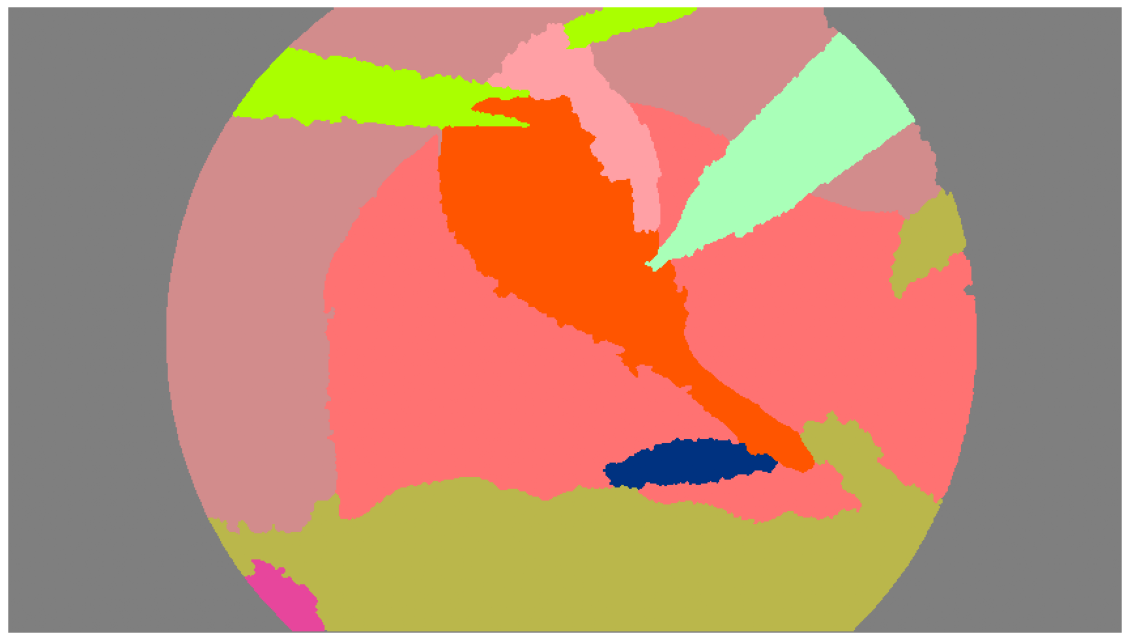

In [ ]:
import matplotlib.pyplot as plt
origin = '/content/masks/endo_1600.png'
# masks=os.listdir(origin)
# for i in masks:
# mask_path=
pic_name = origin
image=plt.imread(pic_name)

fig=plt.figure(figsize=(20,30))
_=plt.imshow(image)
_=plt.axis('off')

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.2 MB/s 


In [ ]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `keras` framework.


In [ ]:
sm.set_framework('tf.keras')

In [ ]:
def data_loader(folder_dir):
    # folder_dir = "../data/semantic_drone_dataset/training_set/images/"
    image_dataset = []
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [ ]:
image_dataset = data_loader("/content/images") # real images...

In [ ]:
mask_dataset = data_loader("/content/masks")

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [ ]:
mask_labels = pd.read_csv('/content/surgery_dup.csv')
mask_labels

,name,r,g,b
0,Black Background,127,127,127
1,Abdominal Wall,210,140,140
2,Liver,255,114,114
3,Gastrointestinal Tract,231,70,156
4,Fat,186,183,75
5,Grasper,170,255,0
6,Connective Tissue,255,85,0
7,Blood,255,0,0
8,Cystic Duct,255,255,0
9,L-hook Electrocautery,169,255,184


In [ ]:
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels...
    return label_seg

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images...
    labels.append(label)

In [ ]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


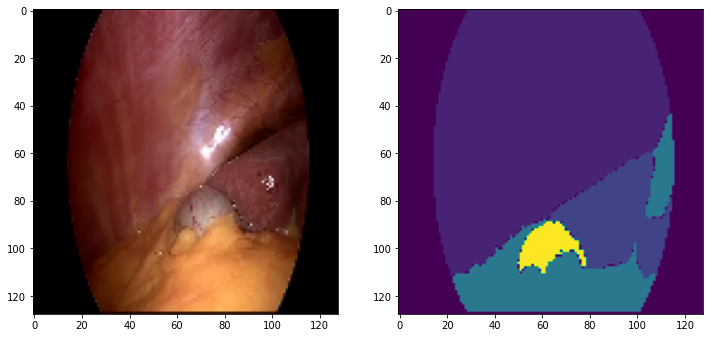

In [ ]:
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [ ]:
n_classes = len(np.unique(labels)) # 23 classes...
labels_cat = to_categorical(labels, num_classes=n_classes) # one hot encoding the labels...

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [ ]:
!rm -rf /content/images
!rm -rf /content/masks